# Solving large scale optimization models with Julia

### Przemysław Szufel, SGH Warsaw School of Economics

Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.

## Quick Julia introduction

In [1]:
# Ctrl + ENTER
versioninfo()

Julia Version 1.9.0
Commit 8e63055292 (2023-05-07 11:25 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 20 × Intel(R) Core(TM) i9-10900X CPU @ 3.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, cascadelake)
  Threads: 16 on 20 virtual cores
Environment:
  JULIA_NUM_THREADS = 16


In [2]:
pwd()

"c:\\Users\\Aryan Ritwajeet Jha\\Documents\\documents_general\\common_code_database\\common_code_database_repo\\solvingLargeScaleOptWithJulia"

In [11]:
using Pkg
Pkg.status("DataFrames")

Status `C:\Users\Aryan Ritwajeet Jha\.julia\environments\v1.9\Project.toml`
⌃ [a93c6f00] DataFrames v1.5.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [7]:
function f(x,y) 
    return x+y
end 

f (generic function with 1 method)

In [8]:
f(3,4)

7

In [9]:
code = Meta.parse(
"""
function f(x,y) 
    x+y
end 
""")

:(function f(x, y)
      #= none:1 =#
      #= none:2 =#
      x + y
  end)

In [7]:
using AbstractTrees
AbstractTrees.print_tree(code);

:(function f(x, y)
      #= none:1 =#
      #= none:2 =#
      x + y
  end)
├─ :(f(x, y))
│  ├─ :f
│  ├─ :x
│  └─ :y
└─ quote
       #= none:1 =#
       #= none:2 =#
       x + y
   end
   ├─ :(#= none:1 =#)
   ├─ :(#= none:2 =#)
   └─ :(x + y)
      ├─ :+
      ├─ :x
      └─ :y


In [8]:
f(1,4)

5

In [9]:
f(5,12)

17

In [10]:
@code_lowered f(5,6)

CodeInfo(
1 ─ %1 = x + y
└──      return %1
)

In [11]:
@code_typed f(4,5)

CodeInfo(
1 ─ %1 = Base.add_int(x, y)::Int64
└──      return %1
) => Int64

In [12]:
@code_llvm f(4,5)

;  @ In[4]:1 within `f`
; Function Attrs: uwtable
define i64 @julia_f_1764(i64 signext %0, i64 signext %1) #0 {
top:
;  @ In[4]:2 within `f`
; ┌ @ int.jl:87 within `+`
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


In [13]:
@code_native f(45,5.0)

	.text
	.file	"f"
	.globl	julia_f_1801                    # -- Begin function julia_f_1801
	.p2align	4, 0x90
	.type	julia_f_1801,@function
julia_f_1801:                           # @julia_f_1801
; ┌ @ In[4]:1 within `f`
	.cfi_startproc
# %bb.0:                                # %top
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset %rbp, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register %rbp
; │ @ In[4]:2 within `f`
; │┌ @ promotion.jl:410 within `+`
; ││┌ @ promotion.jl:381 within `promote`
; │││┌ @ promotion.jl:358 within `_promote`
; ││││┌ @ number.jl:7 within `convert`
; │││││┌ @ float.jl:159 within `Float64`
	vcvtsi2sd	%rcx, %xmm0, %xmm0
; ││└└└└
; ││ @ promotion.jl:410 within `+` @ float.jl:408
	vaddsd	%xmm1, %xmm0, %xmm0
; │└
	popq	%rbp
	retq
.Lfunc_end0:
	.size	julia_f_1801, .Lfunc_end0-julia_f_1801
	.cfi_endproc
; └
                                        # -- End function
	.section	".note.GNU-stack","",@progbits


In [14]:
v = [1,2,3,4]

4-element Vector{Int64}:
 1
 2
 3
 4

In [15]:
# \euler i TAB
# Ctrl + ENTER
ℯ

ℯ = 2.7182818284590...

In [16]:
setprecision(10000)
big(π)

3.14159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127372458700660631558817488152092096282925409171536436789259036001133053054882046652138414695194151160943305727036575959195309218611738193261179310511854807446237996274956735188575272489122793818301194912983367336244065664308602139494639522473719070217986094370277053921717629317675238467481846766940513200056812714526356082778577134275778960917363717872146844090122495343014654958537105079227968925892354201995611212902196086403441815981362977477130996051870721134999999837297804995105973173281609631859502445945534690830264252230825334468503526193118817101000313783875288658753320838142061717766914730359825349042875546873115956286388235378759375195778185778053217122680661300192787661119590921642019

In [17]:
f(a::Int, b::Float64) = a+b
f(a::Float64, b::Float64) = a*b
methods(f)

# 3 methods for generic function "f" from Main:
 [1] f(a::Int64, b::Float64)
     @ In[17]:1
 [2] f(a::Float64, b::Float64)
     @ In[17]:2
 [3] f(x, y)
     @ In[4]:1

In [18]:
f(ComplexF64(32,2), 3)

35.0 + 2.0im

In [19]:
f(4, 5.0)

9.0

In [20]:
f(5.0, 6.0)

30.0

In [21]:
ℯ

ℯ = 2.7182818284590...

In [22]:
typeof(ℯ)

Irrational{:ℯ}

In [23]:
[1, 2, 3, 4.3]

4-element Vector{Float64}:
 1.0
 2.0
 3.0
 4.3

In [12]:
v3 = [ 3x for x ∈ 1:9 ] #Python range(1,10)

9-element Vector{Int64}:
  3
  6
  9
 12
 15
 18
 21
 24
 27

In [25]:
v3[1:end-3]

6-element Vector{Int64}:
  3
  6
  9
 12
 15
 18

In [18]:
# ∑ = sum
∏ = prod
∏(x for x ∈ 1:7)

5040

In [13]:
v₄= [ √x₁ for x₁ ∈ 1:9] 

9-element Vector{Float64}:
 1.0
 1.4142135623730951
 1.7320508075688772
 2.0
 2.23606797749979
 2.449489742783178
 2.6457513110645907
 2.8284271247461903
 3.0

In [28]:
typeof(v₄)

Vector{Float64} (alias for Array{Float64, 1})

In [29]:
eltype(v₄)

Float64

In [30]:
b = Int[]
append!(b, 5)

1-element Vector{Int64}:
 5

In [31]:
c = []
append!(c, 5)

1-element Vector{Any}:
 5

In [32]:
c = Complex(1,4)

1 + 4im

In [33]:
typeof(c)

Complex{Int64}

In [34]:
dump(c)

Complex{Int64}
  re: Int64 1
  im: Int64 4


In [35]:
c2=Complex{Float64}(1,4)

1.0 + 4.0im

In [36]:
typeof(c2)

ComplexF64 (alias for Complex{Float64})

In [37]:
c2=Complex{Float32}(1,4)
typeof(c2)

ComplexF32 (alias for Complex{Float32})

In [38]:
x = 1//2 + 1//4

3//4

In [39]:
typeof(x)

Rational{Int64}

In [40]:
c3=Complex{Rational{Int128}}(1//4,4)
@show c3


c3 = 1//4 + 4//1*im


1//4 + 4//1*im

In [41]:
Complex{Float64}(c3)

0.25 + 4.0im

### Data types

In [42]:
parse(Float64, "3.7")

3.7

In [43]:
one(Float64), zero(UInt128)

(1.0, 0x00000000000000000000000000000000)

In [44]:
typeof((one(Float64), zero(UInt128)))

Tuple{Float64, UInt128}

In [45]:
@show Int64('a') 	# character to integer
@show Int64(2.0) 	# float to integer
#Int64(1.3) 		# inexact error
#Int64("a") 		# error no conversion possible
@show Float64(1) 	# integer to float
@show Bool(1) 		# boolean true
@show Bool(0) 		# boolean false
@show Char(89) 		# integer to char
@show zero(10.0) 	# zero of  arg type (Float64)
@show one(Int64) 	# one of type Int64
@show convert(Int64, 1.0)	# float to integer
@show parse(Int64, "1") 

Int64('a') = 97
Int64(2.0) = 2
Float64(1) = 1.0
Bool(1) = true
Bool(0) = false
Char(89) = 'Y'
zero(10.0) = 0.0
one(Int64) = 1
convert(Int64, 1.0) = 1
parse(Int64, "1") = 1


1

In [46]:
v = Vector{Union{Int, Float64}}()
v = Union{Int, Float64}[]
push!(v, 1)
push!(v, 2.5)
v

2-element Vector{Union{Float64, Int64}}:
 1
 2.5

In [47]:
@show Int <: Any
@show Int <: Union{Int, Float64}
@show typeof(nothing)

Int <: Any = true
Int <: Union{Int, Float64} = true
typeof(nothing) = Nothing


Nothing

In [48]:
f(x) = println("x² = $(x^2) ")

f(66)

x² = 4356 


### Tuples

In [49]:
('a', true)::Tuple{Char, Bool}

('a', true)

In [50]:
@show () 		# empty tuple
@show (1,) 		# one element tuple
@show ("a", 1) 	# two element tuple
@show ('a', false)::Tuple{Char, Bool} # tuple type assertion
@show x = (1, 2, 3)
@show x[1] 		# first element
@show x[1:2] 	# (1, 2) (tuple)
# x[4] 		# bounds error
# x[1] = 1 	# error - tuple is not mutable
@show a, b = x 	# tuple unpacking a==1, b==2


() = ()
(1,) = (1,)
("a", 1) = ("a", 1)
('a', false)::Tuple{Char, Bool} = ('a', false)
x = (1, 2, 3) = (1, 2, 3)
x[1] = 1
x[1:2] = (1, 2)
(a, b) = x = (1, 2, 3)


(1, 2, 3)

In [51]:
t = (3, 3.0)
typeof(t)

Tuple{Int64, Float64}

In [52]:
k = (1, "k",  1//5)
typeof(k)

Tuple{Int64, String, Rational{Int64}}

In [53]:
v = 3:10
typeof(v)


UnitRange{Int64}

In [54]:
collect(1:10)

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

### Matrices

In [55]:
zeros(Int, 2,3)

2×3 Matrix{Int64}:
 0  0  0
 0  0  0

In [56]:
Matrix{Float64}(undef,40, 30 )

40×30 Matrix{Float64}:
 NaN               2.35937e-316  …    1.3126e-311     0.0
   1.061e-313      2.36576e-316       1.08858e-311    1.31263e-311
   1.31263e-311    1.31263e-311       0.0             8.48798e-314
   1.2732e-313     1.31263e-311       1.23678e-314    1.31261e-311
   5.0e-324        1.6e-322         NaN               1.31263e-311
   1.31263e-311  NaN             …    1.31263e-311    1.31263e-311
   1.31263e-311    1.31263e-311       1.31263e-311    4.0e-323
   1.31263e-311    1.31263e-311       0.0             0.0
   1.31263e-311    4.0e-323           0.0             1.31263e-311
   4.0e-323        0.0                1.31255e-311  NaN
   5.4e-323      NaN             …    1.31255e-311  NaN
   3.241e-316    NaN                  1.31309e-311  NaN
   1.31309e-311    1.31263e-311       0.0           NaN
   ⋮                             ⋱                  
  -1.28775e22      1.31139e-311       0.0             1.31262e-311
   3.5e-323        0.0                1.08858e-311  

In [57]:

@show Array{Any}(undef, 2, 3) 	# 2x3 array of Any
@show zeros(5) 				# vector of Float64 zeros
@show ones(Int64, 2, 1) 	# 2x1 array of Int64 ones
@show trues(3), falses(3) 	# tuple of vector of trues and of falses

@show x = range(1, stop=2, length=5)  # iterator having 5 equally spaced elements
@show collect(x) 	# converts iterator to vector
@show 1:10 			# iterable from 1 to 10
@show 1:2:10 		# iterable from 1 to 9 with 2 skip
@show reshape(1:12, 3, 4)	# 3x4 array filled with 1:12 values


Array{Any}(undef, 2, 3) = Any[#undef #undef #undef; #undef #undef #undef]
zeros(5) = [0.0, 0.0, 0.0, 0.0, 0.0]
ones(Int64, 2, 1) = [1; 1;;]
(trues(3), falses(3)) = (Bool[1, 1, 1], Bool[0, 0, 0])
x = range(1, stop = 2, length = 5) = 1.0:0.25:2.0
collect(x) = [1.0, 1.25, 1.5, 1.75, 2.0]
1:10 = 1:10
1:2:10 = 1:2:9
reshape(1:12, 3, 4) = [1 4 7 10; 2 5 8 11; 3 6 9 12]


3×4 reshape(::UnitRange{Int64}, 3, 4) with eltype Int64:
 1  4  7  10
 2  5  8  11
 3  6  9  12

In [58]:
Matrix

Matrix (alias for Array{T, 2} where T)

In [59]:
y = Matrix{Int64}(undef, 2, 3)

2×3 Matrix{Int64}:
               0  140735694314928  140735694306752
 140735694306752                0  140735694314928

In [60]:
m = zeros( 4, 5)
m[1,3] = 66
m
# 1-based numbering 

4×5 Matrix{Float64}:
 0.0  0.0  66.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0

In [61]:
m[1:end-1,3] #array slicing

3-element Vector{Float64}:
 66.0
  0.0
  0.0

In [62]:
a = reshape(Int128(1):Int128(12_000_000_000), 3_000, 4_000_000)
sum(a)

72000000006000000000

In [63]:
a = [1,2,3,4]
b = a'
b[1,1] = 99
a

4-element Vector{Int64}:
 99
  2
  3
  4

In [64]:
a = reshape(1:12, 3, 4)
display(a[:, 3:end]) # 3x2 matrix
display(a[:, 1]) # 3 element vector
display(a[1, :]) # 4 element vector


3×2 Matrix{Int64}:
 7  10
 8  11
 9  12

3-element Vector{Int64}:
 1
 2
 3

4-element Vector{Int64}:
  1
  4
  7
 10

### Data structures

In [65]:
mutable struct Point1
  x::Int
  y::Float64
  meta
end
p = Point1(0, 0.0, "Origin")
@show p
@show p.x 		# access field
p.meta = 2		# change field value
@show fieldnames(typeof(p)) # get names of instance fields
@show fieldnames(Point1); 	# get names of type fields


p = Point1(0, 0.0, "Origin")
p.x = 0
fieldnames(typeof(p)) = (:x, :y, :meta)
fieldnames(Point1) = (:x, :y, :meta)


In [66]:
 fieldnames(Point1)

(:x, :y, :meta)

In [67]:
dump(:x)

Symbol x


In [68]:
dump(p)

Point1
  x: Int64 0
  y: Float64 0.0
  meta: Int64 2


In [69]:
fieldnames(typeof(p))

(:x, :y, :meta)

In [70]:
dump(:a)

Symbol a


In [71]:
Base.@kwdef struct Point2
  x::Int64 = 1
  y::Float64 = 2.0
  meta
end
p2 = Point2(x=999, meta = "Origin")

Point2(999, 2.0, "Origin")

In [72]:
p2

Point2(999, 2.0, "Origin")

In [73]:
try 
    p2.x = 33333
catch e
    println(e)
end

ErrorException("setfield!: immutable struct of type Point2 cannot be changed")


### Dictionaries

In [74]:
using PyCall
"""
x = { 1:"22", 4:"55"}
"""

"x = { 1:\"22\", 4:\"55\"}\n"

In [75]:


x = Dict{Int, Float64}() 
x[5] = 66.6
x[7] = 99
x[73] = 99

x

Dict{Int64, Float64} with 3 entries:
  5  => 66.6
  7  => 99.0
  73 => 99.0

In [76]:
x[5]

66.6

In [77]:
x[111] = 4.5

4.5

In [78]:
x

Dict{Int64, Float64} with 4 entries:
  5   => 66.6
  7   => 99.0
  73  => 99.0
  111 => 4.5

In [79]:
x2 = Dict{Any, Any}() 
x2[5] = 66.6
x2[7] = 99

x2

Dict{Any, Any} with 2 entries:
  5 => 66.6
  7 => 99

In [80]:
typeof( 1=>5 )

Pair{Int64, Int64}

In [81]:
y = Dict( 1=>5.5, 2=>4.5, 3=>77.0 ) 

Dict{Int64, Float64} with 3 entries:
  2 => 4.5
  3 => 77.0
  1 => 5.5

In [82]:
x = Dict{Int, Float64}() # empty dictionary mapping integers to floats
y = Dict(1=>5.5, 2=>4.5) 	# created dictionary
@show y[2] 					# get element
@show y[3] = 30.0 			# add element
@show haskey(y, 2) 			# check if key exists
@show keys(y), values(y) # iterators returning dictionary keys and values
@show delete!(y, 2)   # removing elements see also: pop!
@show get(y, 2, 777) # returns y[2] or 777 if not haskey(y,2)


y[2] = 4.5
y[3] = 30.0 = 30.0
haskey(y, 2) = true
(keys(y), values(y)) = ([2, 3, 1], [4.5, 30.0, 5.5])
delete!(y, 2) = Dict(3 => 30.0, 1 => 5.5)
get(y, 2, 777) = 777


777

### Text processing

In [83]:
x = 123
"$x + 3 = $(x+3)  3\$"  

"123 + 3 = 126  3\$"

In [84]:
"tekst a" * " tekst b"

"tekst a tekst b"

In [85]:
a  = 55

55

In [86]:
println("variable a=$a   and 2a + 5 = $(2*a+5) ")

variable a=55   and 2a + 5 = 115 


In [87]:
@show "Hi " * "there!" 		# concatenation
@show "Ho " ^ 3 			# multiplication
@show string("a= ", 123.3) 	# joining elements to text
@show occursin("CD","ABCD") 	# occurence
@show "\"\n\t\$" # C-like escaping, additionally escape \$ 
                          # escaping - similiar to Matlab, Python, R
x = 123
@show "$x + 3 = $(x+3)"  # $ is an interpolation operator
@show "\$199" # that is why you need escaping

r = r"A|B" # full support for regular expressions
@show occursin(r, "CD") # false, not found
@show m = match(r, "ACBD"); # first regexp match 


"Hi " * "there!" = "Hi there!"
"Ho " ^ 3 = "Ho Ho Ho "
string("a= ", 123.3) = "a= 123.3"
occursin("CD", "ABCD") = true
"\"\n\t\$" = "\"\n\t\$"
"$(x) + 3 = $(x + 3)" = "123 + 3 = 126"
"\$199" = "\$199"
occursin(r, "CD") = false
m = match(r, "ACBD") = RegexMatch("A")


In [88]:
x = 6

tekst = "hello $x and $(x*x+2x)"

"hello 6 and 48"

### Functions

In [89]:
f(x, y = 10) = x + y 
# for this function the default value of y is 10
@show f(3, 2) # 5 is returned
@show f(3)    # 13 is returned





f(3, 2) = 5
f(3) = 13


13

In [90]:
function g(x::Int, y::Int) # limit arg type
  return y, x # tuple returned 
end

g(x::Int, y::Bool) = x * y # multiple dispatch
g(x, y) = x - y
methods(g) # list of methods for g



# 3 methods for generic function "g" from Main:
 [1] g(x::Int64, y::Int64)
     @ In[90]:1
 [2] g(x::Int64, y::Bool)
     @ In[90]:5
 [3] g(x, y)
     @ In[90]:6

In [91]:
@show g(1,2)  
@show g(1, false)
@show g(4.5, 1.5)

g(1, 2) = (2, 1)
g(1, false) = 0
g(4.5, 1.5) = 3.0


3.0

In [92]:
function g(x::Int, y::Int) # limit arg type
  return y, x # tuple returned 
end

g(x::Int, y::Bool) = x * y # multiple dispatch

@show g(1,2)
@show g(1, true)


g(1, 2) = (2, 1)
g(1, true) = 1


1

In [93]:
methods(g)

# 3 methods for generic function "g" from Main:
 [1] g(x::Int64, y::Int64)
     @ In[92]:1
 [2] g(x::Int64, y::Bool)
     @ In[92]:5
 [3] g(x, y)
     @ In[90]:6

In [94]:
@show g(1,4)
@show g(1,true)
methods(g)

g(1, 4) = (4, 1)
g(1, true) = 1


# 3 methods for generic function "g" from Main:
 [1] g(x::Int64, y::Int64)
     @ In[92]:1
 [2] g(x::Int64, y::Bool)
     @ In[92]:5
 [3] g(x, y)
     @ In[90]:6

### Operators

In [95]:
[1 2] .< [2 1]

1×2 BitMatrix:
 1  0

In [96]:
[1 2 3] .< [4 2 2]

1×3 BitMatrix:
 1  0  0

In [97]:
2 .+ [1 2 3; 4 5 6] 

2×3 Matrix{Int64}:
 3  4  5
 6  7  8

In [98]:
f(a,b) = a < b + 1 ? a : b

f (generic function with 4 methods)

In [99]:
f.([1 2 3], [4 2 2])

1×3 Matrix{Int64}:
 1  2  2

In [100]:
@show true || false # binary or operator (singeltons only)
@show 1 < 2 < 3     # condition chaining  is OK 
@show [1 2] .< [2 1] # vectorization via dot operator "."
@show a = 5
@show 2a + 2(a+1) # multiplication can be ommited 
@show x = [1 2 3]	  #matrix 1×3 Array{Int64,2}    
@show y = [1, 2, 3]  #matrix 3-elements Array{Int64,1}
# vectors are vecticar and are different concept than horizontal 1-row matrix
#x + y # error
@show x .+ y # 3x3 matrix, dimension broadcasting
@show x + y' # 1x3 matrix
@show x * y; # array multiplication, 1-element vector (not scalar)


true || false = true
1 < 2 < 3 = true
[1 2] .< [2 1] = Bool[1 0]
a = 5 = 5
2a + 2 * (a + 1) = 22
x = [1 2 3] = [1 2 3]
y = [1, 2, 3] = [1, 2, 3]
x .+ y = [2 3 4; 3 4 5; 4 5 6]
x + y' = [2 4 6]
x * y = [14]


1-element Vector{Int64}:
 14

In [101]:
# dot operator :  . 

In [102]:
[1,2,3] .< [4,2,1]

3-element BitVector:
 1
 0
 0

In [103]:
"""
def f(x,y):
   return 2*x if x < y else -1
"""

"def f(x,y):\n   return 2*x if x < y else -1\n"

In [104]:
f(x,y) =  x<y ? 2x : -1

f (generic function with 4 methods)

In [105]:
f(10,30)


20

In [106]:
a=  [1,2,3]
b=  [0,5,6]

3-element Vector{Int64}:
 0
 5
 6

In [107]:
f.(a,b)

3-element Vector{Int64}:
 -1
  4
  6

In [108]:
a .* b

3-element Vector{Int64}:
  0
 10
 18

# Optimization models

In [109]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
@variable(m,  x₁ >= 0)
@variable(m,  x₂ >= 0)
@objective(m, Min, 50x₁ + 70x₂)
@constraint(m, 200x₁ + 2000x₂ >= 9000)
@constraint(m, 100x₁ +   30x₂ >=  300)
@constraint(m, 9x₁   +   11x₂ >=   60)
println(m)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-08
Min 50 x₁ + 70 x₂
Subject to
 200 x₁ + 2000 x₂ >= 9000
 100 x₁ + 30 x₂ >= 300
 9 x₁ + 11 x₂ >= 60
 x₁ >= 0
 x₂ >= 0



In [110]:
m

A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x₁, x₂

In [111]:
optimize!(m)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xfa09ea2f
Coefficient statistics:
  Matrix range     [9e+00, 2e+03]
  Objective range  [5e+01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 9e+03]
Presolve time: 0.00s
Presolved: 3 rows, 2 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.787500e+02   0.000000e+00      0s
       2    3.8814433e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.881443299e+02

User-callback calls 42, time in user-callback 0.00 sec


In [112]:
value(x₁)


1.7010309278350517

In [113]:
value(4x₁ + 4x₁ + x₂)

17.938144329896907

In [114]:
value.([x₁,x₂])

2-element Vector{Float64}:
 1.7010309278350517
 4.329896907216495

In [115]:
using HiGHS

The same model as above but now the decision variables are expected to be integers

In [116]:
m = Model(HiGHS.Optimizer)
@variable(m, 100 >= x₁ >= 0, Int)
@variable(m, 110 >= x₂ >= 0, Int)
@objective(m, Min, 50x₁ + 70x₂)
@constraint(m, 200x₁ + 2000x₂ >= 9000)
@constraint(m, 100x₁ +   30x₂ >=  300)
@constraint(m, 9x₁   +   11x₂ >=   60)
println(m)

Min 50 x₁ + 70 x₂
Subject to
 200 x₁ + 2000 x₂ >= 9000
 100 x₁ + 30 x₂ >= 300
 9 x₁ + 11 x₂ >= 60
 x₁ >= 0
 x₂ >= 0
 x₁ <= 100
 x₂ <= 110
 x₁ integer
 x₂ integer



In [117]:
optimize!(m)


Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 2 cols, 6 nonzeros
3 rows, 2 cols, 6 nonzeros
Objective function is integral with scale 0.1

Solving MIP model with:
   3 rows
   2 cols (0 binary, 2 integer, 0 implied int., 0 continuous)
   6 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s

Solving report
  Status            Optimal
  Primal bound      450
  Dual bound        450
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    450 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (ro

In [118]:
JuMP.value.([x₁,x₂])

2-element Vector{Float64}:
 2.0
 5.0

In [119]:
#1.9999999999999
round.(Int, value.([x₁,x₂]))

2-element Vector{Int64}:
 2
 5

What are those `@` macros we are seeing around?

In [120]:
code = Meta.parse("x=5")

:(x = 5)

In [121]:
dump(code)

Expr
  head: Symbol =
  args: Array{Any}((2,))
    1: Symbol x
    2: Int64 5


In [122]:
:somysymbolname

:somysymbolname

In [123]:
dump(code)

Expr
  head: Symbol =
  args: Array{Any}((2,))
    1: Symbol x
    2: Int64 5


In [124]:
eval(code)

5

In [125]:
x

5

In [126]:
macro sayhello(name)
    println("Code is being generated")
    return :( println("Hello, ", $name) )
end

@sayhello (macro with 1 method)

In [127]:
@time @sayhello("John")

Code is being generated
Hello, John
  0.000965 seconds (147 allocations: 11.141 KiB)


In [128]:
@time @sayhello("John")

Code is being generated
Hello, John
  0.000735 seconds (26 allocations: 1024 bytes)


In [129]:
@macroexpand @sayhello("John")

Code is being generated


:(Main.println("Hello, ", "John"))

In [130]:
println(@macroexpand @sayhello("John"))

Code is being generated
Main.println("Hello, ", "John")


In [131]:
@sayhello("John")

Code is being generated
Hello, John


In [132]:
println(@macroexpand @variable(m, x₁ >= 0));

begin
    #= In[132]:1 =#
    JuMP._valid_model(m, :m)
    begin
        #= C:\JuliaPkg\Julia-1.9.2\packages\JuMP\H2SWp\src\macros.jl:128 =#
        JuMP._error_if_cannot_register(m, :x₁)
        #= C:\JuliaPkg\Julia-1.9.2\packages\JuMP\H2SWp\src\macros.jl:136 =#
        var"#188###340" = JuMP.add_variable(m, JuMP.build_variable(JuMP.var"#_error#103"{LineNumberNode}(:(#= In[132]:1 =#), Core.Box((:m, :(x₁ >= 0)))), JuMP.VariableInfo(true, 0, false, NaN, false, NaN, false, NaN, false, false)), if JuMP.set_string_names_on_creation(m)
                    "x₁"
                else
                    ""
                end)
        #= C:\JuliaPkg\Julia-1.9.2\packages\JuMP\H2SWp\src\macros.jl:137 =#
        m[:x₁] = var"#188###340"
        #= C:\JuliaPkg\Julia-1.9.2\packages\JuMP\H2SWp\src\macros.jl:143 =#
        x₁ = var"#188###340"
    end
end


In [133]:
using Calculus

In [134]:
Meta.parse("(sin(x) + x*x+5x)")

:(sin(x) + x * x + 5x)

In [135]:
using AbstractTrees
AbstractTrees.print_tree(:(sin(x) + x*x+5x))

:(sin(x) + x * x + 5x)
├─ :+
├─ :(sin(x))
│  ├─ :sin
│  └─ :x
├─ :(x * x)
│  ├─ :*
│  ├─ :x
│  └─ :x
└─ :(5x)
   ├─ :*
   ├─ 5
   └─ :x


In [136]:
AbstractTrees.print_tree(differentiate(:(sin(x) + x*x+5x)))

:(1 * cos(x) + (1x + x * 1) + (0 * x + 5 * 1))
├─ :+
├─ :(1 * cos(x))
│  ├─ :*
│  ├─ 1
│  └─ :(cos(x))
│     ├─ :cos
│     └─ :x
├─ :(1x + x * 1)
│  ├─ :+
│  ├─ :(1x)
│  │  ├─ :*
│  │  ├─ 1
│  │  └─ :x
│  └─ :(x * 1)
│     ├─ :*
│     ├─ :x
│     └─ 1
└─ :(0 * x + 5 * 1)
   ├─ :+
   ├─ :(0 * x)
   │  ├─ :*
   │  ├─ 0
   │  └─ :x
   └─ :(5 * 1)
      ├─ :*
      ├─ 5
      └─ 1


### Subway optimization

In [137]:
using JuMP, HiGHS
using DelimitedFiles

In [138]:
S = 18   # number of warehouses
D = 100  # number of restaurants
supply = fill(100,S)
demand = fill(15,D);

In [139]:
dat="""21328	7901	16774	24413	14131	21551	15742	21091	25167	3266	19312	14878	22914	18392	14514	21072	11535	12965	12952	12952	15839	27836	16816	13527	13769	4924	23891	26532	10245	15446	16834	11421	27231	20285	25810	12477	16499	26958	23770	32327	23572	26475	23894	2054	22156	28491	2392	21051	18793	14598	9413	8004	14286	8717	24919	27581	21829	26135	33450	4905	18558	23046	9212	20923	6426	20020	24644	10862	12351	16446	7751	19819	17406	16768	9319	17584	8191	18776	22432	20389	25377	3129	22425	6899	16830	12305	3393	24579	16727	21086	30660	26999	29664	26436	26138	28183	20874	30143	30419	29718
5195	15055	4216	9295	6050	4779	3641	15102	8395	16829	5224	3595	14177	1684	2753	4300	5469	4233	3962	3962	3039	13176	12595	4764	5428	12767	7119	11115	6960	1597	1173	5848	26351	10941	19927	7174	13542	11015	6998	18198	18270	9703	7376	15867	21981	12387	19029	6936	9170	15206	7748	8933	11906	12823	24031	21698	8083	11432	18205	18548	17558	25919	10027	7178	10521	19897	29294	15136	13659	10764	18656	7135	9574	19550	13973	11620	17524	10944	9910	9940	26373	13762	11058	16154	22702	19728	14022	13212	4280	7563	22298	13152	15728	12308	17068	19554	12880	16313	18674	20915
24025	13295	22003	22254	20379	26418	22859	10495	28761	12735	29656	23437	36220	24616	24042	28477	24395	24758	25121	25121	26548	22646	30633	22842	26491	16326	27452	24373	23067	25325	26551	21542	15677	33471	14651	19634	30316	26735	29375	24969	12413	28023	29753	17066	10602	28267	17790	19925	31979	11657	20017	21593	15001	22657	12101	16422	32830	33810	28260	19918	7961	10227	17414	32204	20070	8789	9898	25254	26654	15742	22269	18946	30636	6105	14423	31182	22709	32007	34792	15723	12559	17643	34786	12754	2900	26823	15171	36939	28008	19237	19501	18955	20687	20740	15099	17024	13131	22051	19380	18559
22508	22014	17954	25593	16490	22230	16922	24989	25524	22994	19299	15807	6155	19098	15443	21468	12730	13765	13698	13698	16518	29016	5152	14712	12407	19272	24570	27712	12077	16125	17442	13516	36239	9317	29815	14836	4483	28138	23911	33506	28157	27086	24005	18712	31869	29670	18413	22231	11140	22962	14736	13031	19351	12074	33919	31585	16632	23191	34630	15865	26772	35807	17273	14708	14646	29784	39182	9608	8373	18948	12547	20876	8411	28622	21042	6315	12007	7728	12270	22466	36261	17719	9635	23113	31385	8204	20527	7661	15899	22181	34494	28057	30721	27616	29264	31749	23716	31201	32314	33111
12913	5006	10217	14089	7574	15206	10375	9595	18453	9762	18403	10736	23395	12829	11221	17256	11328	11937	12300	12300	13779	17052	17405	10020	13666	7932	17144	16209	9839	13158	14563	8314	17138	20646	14521	6406	17088	16684	19067	21542	12283	17714	19445	11789	12768	18217	15071	10777	19154	2717	6596	8172	2025	9318	14805	16292	20943	23502	22666	14640	7256	16706	3917	20037	6821	10026	20081	11915	13233	4235	14855	9053	17812	8378	3697	18089	14029	19182	22625	8169	17147	9683	22619	6321	11174	17884	9520	24772	15841	10116	19371	16003	18668	15652	14502	16894	8883	19148	18556	18349
6281	16514	5753	10410	7509	5795	5099	16782	9308	18288	3312	4999	12625	2798	4158	5230	4648	3949	3341	3341	2010	14262	11741	5686	4491	14172	8135	12202	6139	1903	833	7252	28032	9390	21608	8633	12688	12061	7800	19313	19950	10719	7894	15046	23662	13403	18173	8050	7618	16665	9152	8112	13364	11967	25712	23378	6171	10135	19220	17692	19239	27600	11486	5266	9700	21577	30975	14265	12788	12222	17785	8823	8548	21230	15432	10622	16653	9685	7998	11620	28054	12940	9507	17612	24382	18873	15427	11660	3003	8736	23737	14267	16842	13422	18513	21173	14561	17427	19876	22534
4656	19128	9008	4124	11894	5115	10216	15084	4473	23560	7924	11296	21642	8036	12133	5794	14532	13370	13273	13273	12492	5169	21810	12436	14643	21431	3145	2102	16062	11050	9979	14704	26333	18420	19909	13545	22757	1361	5712	10225	18252	3044	6090	24906	21963	2893	28161	5968	16648	16074	16577	18035	13324	21984	24014	21680	11094	10146	8657	27685	17540	25902	17061	12978	19586	19879	29276	24306	22830	12163	27827	7636	18788	19532	17819	20835	26694	20159	15710	9922	26355	22801	18447	20443	22684	28942	22852	20547	13660	6657	21239	9808	12248	7988	16401	19061	12862	10557	16997	20422
16446	6905	14412	14675	11772	18839	14588	7393	21182	11243	22077	14949	27612	17024	15434	20898	15787	16151	16513	16513	17993	16064	22025	14234	17883	9936	19873	16795	14459	17371	18776	12934	14600	24863	12201	11026	21708	19156	21796	20555	9963	20444	22174	13463	10230	20688	16645	12347	23371	2861	11340	12916	6325	14030	12267	13972	25156	26231	21678	16314	4936	12206	8733	24250	11443	6518	15339	16627	17978	7135	16968	11368	22029	3256	5796	22574	17408	23399	26839	8145	14538	11797	26832	8220	6019	21522	11470	28986	20054	11658	17050	15108	17399	14664	12468	14574	6924	18252	16749	16109
12070	11940	10048	10299	8061	14463	10878	2839	16806	16286	17701	11239	23901	12661	11724	16522	12122	12440	12803	12803	14282	11080	18749	10523	14172	14959	15497	12419	11183	13370	14597	9658	14089	21152	7665	7700	18432	14780	17420	15539	6007	16068	17798	18505	9719	16312	21688	7971	19661	5094	10528	12139	5548	16015	11769	9435	20875	21855	16694	21357	5295	13657	10644	20249	13538	7634	17032	18604	17127	3353	21847	6992	18318	7287	10724	18909	20725	19688	22837	3769	14111	16676	22831	13254	10342	24395	16513	24984	16053	7282	12491	9848	12040	9648	7426	9830	1565	12993	11480	11273
10329	23462	13628	6311	16247	10788	14836	14910	7331	27913	13481	15916	27214	13710	16784	11351	19112	17990	17893	17893	18028	2647	26430	16997	19262	25789	8815	4323	20625	16722	15636	19217	26160	23992	19703	17898	27377	4669	9312	5419	18078	5880	9548	29264	21790	5165	32546	9541	22221	17837	20935	22545	17686	26421	23840	21156	16651	13619	3334	32102	17366	25728	21419	18550	23944	19705	29103	28886	27409	15635	32264	11041	23408	19358	22153	25455	31131	24779	21282	11857	26182	27159	24019	24777	22510	33562	27210	26120	19317	9710	19225	7343	9606	5523	14848	17430	12203	7915	14982	18439
9046	7229	6350	10918	3587	11339	6397	7802	14626	11985	14424	6758	19420	8962	7243	13389	7493	7959	8322	8322	9801	14306	13857	6042	9691	10151	13317	13037	6291	9180	10585	4767	19051	16671	12628	2808	13541	13463	15240	18797	10970	13888	15618	13923	14681	14996	17205	7556	15180	6200	5636	7247	2636	11123	16732	14398	16964	19675	19921	16774	9996	18620	5807	16059	8646	12597	21994	13712	12236	1761	16966	5969	13837	11847	5920	14279	15834	15208	18647	5814	19073	11817	18641	8544	14609	19504	11740	20794	11863	7254	17377	13258	15923	12907	12147	14632	6528	16403	16201	15994
4657	14007	4438	3771	6792	7050	5646	9018	9393	18458	10288	6726	19802	5879	7594	9109	9647	8800	8703	8703	8838	7010	17078	7532	10073	16334	8084	5890	11170	7533	8037	9762	20267	16877	13843	8443	18024	7499	10007	11501	12186	8655	10385	19810	15897	9032	23092	475	15105	10063	11480	13090	8130	16966	17948	15614	13462	14442	12625	22647	11474	19836	11964	13509	14489	13813	23210	19421	17945	6236	22809	1641	14219	13466	12699	15994	21677	15589	16241	3856	20289	17704	16993	15322	16618	24210	17755	19147	10215	239	15528	6455	8962	5611	10304	12964	6796	9616	11742	14325
16168	26420	17376	13468	19205	18438	18584	14330	20479	30871	21676	19664	32739	18651	20532	20497	22329	21738	21641	21641	21776	11708	29491	20520	23011	28747	19444	14693	23583	20470	20809	22175	13538	29815	9415	20856	30437	17221	21396	8872	12092	19047	21773	32223	13988	18752	35504	13302	28043	20840	23893	25503	20740	29379	14349	9468	24851	25830	16745	35060	16582	17173	24377	25029	26902	15501	19174	31968	30491	18559	35222	13999	27156	18554	25111	28487	34089	28527	27761	14815	16400	30117	29931	27735	21545	36623	30168	32085	23153	13264	6197	7925	4260	9841	9124	7119	14589	5954	5049	5752
3485	11419	1299	6632	4185	5779	2507	10988	9414	15851	9008	3586	16662	3402	4455	7829	6823	5661	5564	5564	5416	10055	14101	4742	6933	13733	8106	8751	8353	4111	5337	6995	22238	13455	15814	5836	15048	8923	10029	14546	14156	8763	10407	17212	17868	10455	20452	3270	11683	11254	8883	10326	7960	14275	19918	17585	11895	14463	15669	19976	13445	21806	9362	10990	11892	15784	25181	16597	15121	6811	20117	2917	11079	15437	10110	13126	18985	12450	13578	5827	22260	15107	13572	12733	18588	21233	15158	15725	6794	3345	18185	9500	12007	8655	12955	15440	8767	12661	14455	16802
20790	9466	18768	19019	16388	23183	19204	8048	25526	11781	26421	19566	32228	21381	20050	25242	20403	20767	21130	21130	22609	19411	26641	18850	22499	12497	24217	21138	19075	21988	23316	17550	14121	29479	12701	15643	26324	23500	26140	22523	10462	24788	26518	14435	9046	25032	17184	16690	27988	7647	16008	17583	10992	18647	11810	14471	29595	30575	25025	17287	5515	9936	13405	28867	16060	6910	13069	21244	22645	11751	19529	15711	26645	3659	10414	27190	19969	28015	31455	12488	12268	14358	31448	9386	3721	24083	12443	33602	24671	16002	17550	16509	18607	17505	13028	15073	9896	19605	17309	16608
5209	18274	7514	9447	9270	4512	6860	18543	7991	20049	1770	6760	12619	4480	5919	3913	6409	5710	5102	5102	3771	13094	13449	7447	6252	15933	6849	11034	7900	3664	2533	9013	29793	9396	23369	10394	14396	10775	6403	19042	21711	9433	6497	16807	25423	12117	19933	9297	7625	18426	10913	9872	15125	13727	27473	25139	4829	8593	17935	19453	20999	29361	13247	3955	11460	23338	32736	15967	14491	13983	19488	10504	10133	22991	17193	12207	18355	11270	6687	13381	29815	14701	9423	19373	26143	20582	17188	11524	4764	9986	25177	14146	17374	13177	20016	22675	16322	17157	20935	24036
11294	12965	9272	9523	8056	13686	10128	2354	16029	17305	16925	10705	23655	11884	11574	15745	12558	12435	12683	12683	13816	9914	19729	10518	13926	15996	14721	11642	12295	12593	13820	10771	13604	20906	7180	8812	19545	14003	16644	14373	5522	15291	17022	19525	9234	15536	22708	7194	19415	6113	11640	13251	6661	17127	11284	8951	20099	21078	15528	22377	4811	13172	11756	19472	14650	7150	16547	19716	18239	4465	22960	6215	18072	6803	11837	18726	21838	19442	22060	2992	13626	17788	22054	14280	9954	25508	17533	24208	15276	6505	11490	8682	10874	8483	6260	8746	400	11827	10314	10107
5303	9560	2607	8328	2468	7596	3463	9535	11232	14134	10826	4040	16990	5219	4909	9646	5902	6115	6018	6018	7151	11553	13064	4295	7261	12016	9923	10447	6988	5928	7155	5580	20785	14241	14361	4119	14011	10873	11846	16044	12703	10580	12224	15533	16415	12406	18815	4966	12750	9395	7204	8813	6101	12689	18465	16131	13713	16281	17167	18371	11992	20353	7646	12807	10213	14330	23728	15278	13802	4953	18532	3288	11407	13983	8252	12061	17400	12778	15396	4373	20807	13428	15389	10875	17135	20196	13479	17543	8611	4601	16731	10469	13133	10153	11502	13987	7314	13613	14444	15348
""";

In [140]:
c = readdlm(IOBuffer(dat), Int)

18×100 Matrix{Int64}:
 21328   7901  16774  24413  14131  …  28183  20874  30143  30419  29718
  5195  15055   4216   9295   6050     19554  12880  16313  18674  20915
 24025  13295  22003  22254  20379     17024  13131  22051  19380  18559
 22508  22014  17954  25593  16490     31749  23716  31201  32314  33111
 12913   5006  10217  14089   7574     16894   8883  19148  18556  18349
  6281  16514   5753  10410   7509  …  21173  14561  17427  19876  22534
  4656  19128   9008   4124  11894     19061  12862  10557  16997  20422
 16446   6905  14412  14675  11772     14574   6924  18252  16749  16109
 12070  11940  10048  10299   8061      9830   1565  12993  11480  11273
 10329  23462  13628   6311  16247     17430  12203   7915  14982  18439
  9046   7229   6350  10918   3587  …  14632   6528  16403  16201  15994
  4657  14007   4438   3771   6792     12964   6796   9616  11742  14325
 16168  26420  17376  13468  19205      7119  14589   5954   5049   5752
  3485  11419   1299   6632  

In [141]:
m = Model(HiGHS.Optimizer);
@variable(m, 400 >= x[i=1:S, j=1:D] >= 0, Int)

18×100 Matrix{VariableRef}:
 x[1,1]   x[1,2]   x[1,3]   x[1,4]   …  x[1,98]   x[1,99]   x[1,100]
 x[2,1]   x[2,2]   x[2,3]   x[2,4]      x[2,98]   x[2,99]   x[2,100]
 x[3,1]   x[3,2]   x[3,3]   x[3,4]      x[3,98]   x[3,99]   x[3,100]
 x[4,1]   x[4,2]   x[4,3]   x[4,4]      x[4,98]   x[4,99]   x[4,100]
 x[5,1]   x[5,2]   x[5,3]   x[5,4]      x[5,98]   x[5,99]   x[5,100]
 x[6,1]   x[6,2]   x[6,3]   x[6,4]   …  x[6,98]   x[6,99]   x[6,100]
 x[7,1]   x[7,2]   x[7,3]   x[7,4]      x[7,98]   x[7,99]   x[7,100]
 x[8,1]   x[8,2]   x[8,3]   x[8,4]      x[8,98]   x[8,99]   x[8,100]
 x[9,1]   x[9,2]   x[9,3]   x[9,4]      x[9,98]   x[9,99]   x[9,100]
 x[10,1]  x[10,2]  x[10,3]  x[10,4]     x[10,98]  x[10,99]  x[10,100]
 x[11,1]  x[11,2]  x[11,3]  x[11,4]  …  x[11,98]  x[11,99]  x[11,100]
 x[12,1]  x[12,2]  x[12,3]  x[12,4]     x[12,98]  x[12,99]  x[12,100]
 x[13,1]  x[13,2]  x[13,3]  x[13,4]     x[13,98]  x[13,99]  x[13,100]
 x[14,1]  x[14,2]  x[14,3]  x[14,4]     x[14,98]  x[14,99]  x[14,100]
 

In [142]:
∑ = sum

sum (generic function with 14 methods)

In [143]:
for j=1:D
   @constraint(m, ∑(x[:, j]) >= demand[j]   )
end
for i=1:S
   @constraint(m, ∑(x[i, :]) <= supply[i]   )
end
#@objective(m, Min, ∑( x[i, j]*c[i, j] for i=1:S, j=1:D))
@objective(m, Min, ∑( x .* c ));

In [144]:
optimize!(m)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118 rows, 1800 cols, 3600 nonzeros
118 rows, 1800 cols, 3600 nonzeros
Objective function is integral with scale 1

Solving MIP model with:
   118 rows
   1800 cols (0 binary, 1800 integer, 0 implied int., 0 continuous)
   3600 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 T       0       0         0   0.00%   0               7994805          100.00%        0      0      0       144     0.0s

Solving report
  Status            Optimal
  Primal bound      7994805
  Dual bound        7994805
  Gap               0% (tolerance: 0.01%)
  Solu

In [145]:
@show termination_status(m)


termination_status(m) = MathOptInterface.OPTIMAL


OPTIMAL::TerminationStatusCode = 1

In [146]:
typeof(termination_status(m))

Enum MathOptInterface.TerminationStatusCode:
OPTIMIZE_NOT_CALLED = 0
OPTIMAL = 1
INFEASIBLE = 2
DUAL_INFEASIBLE = 3
LOCALLY_SOLVED = 4
LOCALLY_INFEASIBLE = 5
INFEASIBLE_OR_UNBOUNDED = 6
ALMOST_OPTIMAL = 7
ALMOST_INFEASIBLE = 8
ALMOST_DUAL_INFEASIBLE = 9
ALMOST_LOCALLY_SOLVED = 10
ITERATION_LIMIT = 11
TIME_LIMIT = 12
NODE_LIMIT = 13
SOLUTION_LIMIT = 14
MEMORY_LIMIT = 15
OBJECTIVE_LIMIT = 16
NORM_LIMIT = 17
OTHER_LIMIT = 18
SLOW_PROGRESS = 19
NUMERICAL_ERROR = 20
INVALID_MODEL = 21
INVALID_OPTION = 22
INTERRUPTED = 23
OTHER_ERROR = 24

In [147]:

value.(x)

18×100 Matrix{Float64}:
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  15.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  15.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0  15.0   0.0  15.0  15.0  15.0
 

In [148]:
using SparseArrays
sparse(value.(x))

18×100 SparseMatrixCSC{Float64, Int64} with 109 stored entries:
⎡⠀⠀⠀⠈⠀⠖⠂⠒⠀⠄⡀⠐⠂⠀⠠⠀⠀⠁⠈⠀⠀⡀⠀⠈⢀⢀⢠⠄⠁⢀⢄⠀⠈⠠⠬⠀⠀⠀⠀⠀⎤
⎢⠐⠀⠀⠒⠀⠀⠀⠈⢁⠈⠒⡀⠀⠡⠀⢂⠐⠂⡂⠑⠀⠀⠄⡀⠂⠀⠂⠀⠈⠂⠈⠀⠀⠂⠀⠁⠀⡀⠀⠀⎥
⎢⠄⠅⠤⠀⡠⠀⠀⠄⠀⠀⠀⠁⠈⡂⠁⠀⠀⢀⠀⠁⠉⠀⢀⠀⢀⡀⠀⠉⠈⠀⠀⡀⣀⠀⠀⠈⠚⠀⠒⠒⎥
⎣⠀⠐⠀⠁⠀⠀⠐⠀⠀⠂⠀⠂⠀⠉⠀⠀⠁⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠈⠈⠀⎦

In [149]:
round.(Int, value.(x)) ≈ value.(x)

true

In [150]:
objective_value(m)

7.994805e6

### Travelling salesman problem (TSP)

In [151]:
dist_mx = [0	17015	15303	20376	12648	16060	25600	14217	19545	30228	14726	21078	33787	18041	14937	17542	20542	16535	21328	7901	16774	24413	14131	21551	15742	21091	25167	3266	19312	14878	22914	18392	14514	21072	11535	12965	12952	12952	15839	27836;
16837	0	25356	17812	13534	1912	9654	17639	13597	15441	9377	7410	19851	4218	22311	3454	12747	6168	5195	15055	4216	9295	6050	4779	3641	15102	8395	16829	5224	3595	14177	1684	2753	4300	5469	4233	3962	3962	3039	13176;
15660	25640	0	34363	13497	27290	25638	8902	13080	25038	17262	19451	23966	21412	6475	28799	12799	19902	24025	13295	22003	22254	20379	26418	22859	10495	28761	12735	29656	23437	36220	24616	24042	28477	24395	24758	25121	25121	26548	22646;
20378	17694	34039	0	20952	16668	26779	25408	22341	31408	17228	22258	34845	19221	30215	17941	23384	18694	22508	22014	17954	25593	16490	22230	16922	24989	25524	22994	19299	15807	6155	19098	15443	21468	12730	13765	13698	13698	16518	29016;
12758	13651	13828	21135	0	15151	15588	5176	7509	19444	4278	10350	22791	9625	10004	16632	8551	7771	12913	5006	10217	14089	7574	15206	10375	9595	18453	9762	18403	10736	23395	12829	11221	17256	11328	11937	12300	12300	13779	17052;
16015	1958	27036	16957	14992	0	10700	19097	15278	16499	10835	8524	20966	5921	23905	1542	14428	7849	6281	16514	5753	10410	7509	5795	5099	16782	9308	18288	3312	4999	12625	2798	4158	5230	4648	3949	3341	3341	2010	14262;
25876	9612	25338	27027	15004	10657	0	17917	13580	5809	12445	6443	16347	7810	22293	9558	12729	9769	4656	19128	9008	4124	11894	5115	10216	15084	4473	23560	7924	11296	21642	8036	12133	5794	14532	13370	13273	13273	12492	5169;
14417	17865	8673	25755	4815	19364	18059	0	5596	18456	8654	11873	21416	13820	4849	20846	6592	11966	16446	6905	14412	14675	11772	18839	14588	7393	21182	11243	22077	14949	27612	17024	15434	20898	15787	16151	16513	16513	17993	16064;
19460	13685	12996	22480	7089	15336	13683	5712	0	13472	5106	7497	16147	9457	9192	16844	1234	7947	12070	11940	10048	10299	8061	14463	10878	2839	16806	16286	17701	11239	23901	12661	11724	16522	12122	12440	12803	12803	14282	11080;
30234	15269	25164	31647	19366	16315	5673	18651	13668	0	16883	9759	13705	12809	22119	15216	12556	14103	10329	23462	13628	6311	16247	10788	14836	14910	7331	27913	13481	15916	27214	13710	16784	11351	19112	17990	17893	17893	18028	2647;
14892	9673	17263	17588	4258	11172	12366	8632	5154	16699	0	7384	20046	5758	13440	12654	6196	3904	9046	7229	6350	10918	3587	11339	6397	7802	14626	11985	14424	6758	19420	8962	7243	13389	7493	7959	8322	8322	9801	14306;
20779	7534	19272	22294	9811	8776	6402	11851	7513	9403	7336	0	13086	3620	16227	9926	6663	4648	4657	14007	4438	3771	6792	7050	5646	9018	9393	18458	10288	6726	19802	5879	7594	9109	9647	8800	8703	8703	8838	7010;
33192	20306	24017	34707	22295	21548	16347	21600	16054	13630	19961	13477	0	16558	22049	21445	14942	17061	16168	26420	17376	13468	19205	18438	18584	14330	20479	30871	21676	19664	32739	18651	20532	20497	22329	21738	21641	21641	21776	11708;
18182	4426	21242	19317	9588	6076	7562	13686	9484	12447	5453	3297	16130	0	18198	7585	8634	2059	3485	11419	1299	6632	4185	5779	2507	10988	9414	15851	9008	3586	16662	3402	4455	7829	6823	5661	5564	5564	5416	10055;
14987	22405	6375	30372	9487	23980	22403	4893	9113	21803	13270	16216	21976	18177	0	25462	9564	16582	20790	9466	18768	19019	16388	23183	19204	8048	25526	11781	26421	19566	32228	21381	20050	25242	20403	20767	21130	21130	22609	19411;
17776	3658	28797	18666	16753	1761	9415	20858	17039	15214	12596	9773	21497	7682	25666	0	16189	9610	5209	18274	7514	9447	9270	4512	6860	18543	7991	20049	1770	6760	12619	4480	5919	3913	6409	5710	5102	5102	3771	13094;
20480	12908	12608	23592	8201	14559	12906	6659	1112	12306	6218	6720	14981	8680	9564	16068	0	7171	11294	12965	9272	9523	8056	13686	10128	2354	16029	17305	16925	10705	23655	11884	11574	15745	12558	12435	12683	12683	13816	9914;
16503	6243	19789	18281	7729	7894	9574	11828	8031	13945	3594	4731	17257	2015	16635	9403	7181	0	5303	9560	2607	8328	2468	7596	3463	9535	11232	14134	10826	4040	16990	5219	4909	9646	5902	6115	6018	6018	7151	11553;
21599	5356	23780	22734	12944	6512	4559	16359	12022	10347	8870	4592	16288	3518	20735	5531	11172	5476	0	14836	4716	4238	7602	2790	5924	13526	6105	19268	6020	7003	17779	3751	7819	4840	10240	9078	8981	8981	8209	8081;
7857	15112	13704	22169	5184	16611	19177	6973	12160	23548	7225	14334	26860	11619	9791	18093	13156	9764	14906	0	12210	17931	9181	17075	11836	14080	20835	4820	19863	12197	24516	14669	12682	19125	12572	13398	13761	13761	15240	21156;
16895	4392	21878	18019	10219	5892	8860	14318	10120	13488	6084	4338	17171	1301	18833	7374	9270	2691	4588	12050	0	7673	4076	5894	1208	11624	9813	14906	9124	2288	15363	3488	3156	7944	5524	4362	4265	4265	5193	11096;
24348	9392	22086	25619	13415	10603	4086	14665	10327	6404	10856	3801	13508	6782	19041	9622	9477	8252	4345	17612	7601	0	10396	5506	8809	11832	7814	22062	8930	9888	21869	7737	10757	7533	13085	11963	11866	11866	12000	4056;
14132	6093	20346	16695	7583	7592	12111	11714	8191	16482	3384	7267	19793	4552	16522	9074	8119	2537	7839	9201	3822	10865	0	8055	2817	10474	11975	11763	10844	3178	15840	5650	3662	10106	4502	4379	4742	4742	6221	14090;
21436	4723	26289	22411	15307	5769	5072	18868	14531	10881	11172	7101	18750	5829	23244	4673	13681	7779	2740	17138	5827	5517	8192	0	6327	16035	3919	19343	3552	7406	16757	3376	7353	2373	10069	8833	8561	8561	7639	8817;
15687	3789	22924	16811	10402	5288	9892	14507	10983	14520	6245	5370	18203	2333	19315	6770	10316	3737	5620	11923	1066	8705	2918	6156	0	12670	10075	13698	8540	1080	14155	3750	1948	7846	4316	3154	3057	3057	3985	12128;
21045	15226	10254	25146	9186	16877	15224	7459	2666	14624	7772	9038	14277	10998	7984	18386	2386	9488	13611	13852	11589	11840	10374	16004	12446	0	18347	17870	19242	13023	25973	14202	13891	18063	14789	14753	15000	15000	16134	12232;
25093	8380	28419	25988	17792	9365	4449	20998	16661	7422	14499	9231	20447	9297	25375	8231	15811	11255	6033	20614	9633	7647	11998	3972	10133	18165	0	23149	6373	11212	20107	7182	11009	4244	13725	12489	12218	12218	11295	9268;
3269	17087	12447	23091	9425	18535	23676	10994	16323	28047	11778	18833	31359	16118	11733	20016	17319	14102	19392	4764	14895	22430	11699	19128	13889	17868	23048	0	21787	14225	25619	16722	14491	21144	14247	15207	15570	15570	17049	25655;
19370	5218	29555	19904	18347	3354	7939	22134	17796	13628	14190	10366	22016	8979	26510	2032	16946	10929	5890	19868	8977	8967	10863	3548	8454	19301	6286	21642	0	8354	13849	6031	7512	2230	8002	7303	6695	6695	5364	12267;
15123	3742	23129	16247	10398	5189	10973	14503	10979	15601	6241	6451	19284	3414	19310	6671	10520	3928	6701	11919	2147	9786	2914	7237	1115	12875	11156	13694	8441	0	13591	4046	1289	7798	3752	2590	2493	2493	3730	13209;
23066	12913	36235	6148	23328	11248	21677	27604	24080	27384	19342	18864	31697	15567	32411	12509	23813	17221	17470	24390	15398	21598	16015	16775	14408	26168	20042	25682	13816	13293	0	13987	12929	15985	12394	11789	11185	11185	11655	25357;
18306	1655	24425	19281	12816	2898	8020	16914	12666	13807	8681	5726	18168	3338	21380	4425	11816	5288	3560	14647	3336	7611	5684	3220	3721	14171	7140	16834	6173	4291	15523	0	4102	5029	6939	5703	5431	5431	4509	11541;
14792	2858	23883	15916	11147	4305	11899	15252	11728	16527	6990	7377	20210	4340	20060	5787	11446	4854	7592	12668	3073	10712	3664	7283	2041	13801	11010	14409	7557	926	13261	4086	0	6915	3422	2259	2162	2162	2847	14135;
20940	4227	28327	21915	17230	5179	5981	20906	16569	11732	13095	9139	20788	7752	25283	4045	15719	9701	4662	19061	7750	7739	10115	2321	7744	18073	4390	20933	2200	7698	15933	4990	6857	0	9572	8336	8065	8065	7142	11040;
11410	5695	24148	12807	11182	4838	14370	15516	12038	18999	7130	9803	22682	6812	20324	6320	12537	6289	10099	12463	5545	13184	4544	10230	4538	14686	13846	14019	8090	3645	12463	7098	3281	9751	0	1743	1730	1730	4518	16606;
13077	4452	24715	14052	11979	4191	13470	16084	12560	18098	7822	8948	21781	5911	20892	5673	12489	6127	9198	13500	4644	12283	4496	8987	3612	14843	12603	15241	7443	2497	11952	5855	2133	8508	1710	0	880	880	3275	15706;
13133	4063	25053	14108	12317	3692	13081	16422	12899	17709	8160	8559	21392	5523	21230	5174	12629	6036	8810	13799	4255	11895	4834	8599	3223	14983	12215	15468	6944	2108	11453	5467	1745	8120	1765	608	0	0	2886	15317;
13133	4063	25053	14108	12317	3692	13081	16422	12899	17709	8160	8559	21392	5523	21230	5174	12629	6036	8810	13799	4255	11895	4834	8599	3223	14983	12215	15468	6944	2108	11453	5467	1745	8120	1765	608	0	0	2886	15317;
14506	3112	26511	15448	13883	2991	12511	17988	14464	17843	9726	8693	21526	5396	22796	4473	13902	7323	8052	15364	5083	12028	6400	7648	4050	16257	11264	17034	6243	3674	12711	4516	2915	7169	3139	2440	1832	1832	0	15451;
27829	13231	22760	29340	16962	14388	4973	16247	11264	2392	14487	7453	11758	10503	19715	13298	10151	11698	8249	21057	11322	4107	13842	8754	12530	12506	9105	25508	12177	13609	25382	11629	14478	10768	16798	15683	15587	15587	15721	0;
];

In [152]:
using JuMP, HiGHS
N = 25 #the problem is NP-hard we do not solve it for all cities
m = Model(optimizer_with_attributes(HiGHS.Optimizer));
JuMP.set_silent(m)
@variable(m, x[f=1:N, t=1:N], Bin)
@objective(m, Min, sum( x[i, j]*dist_mx[i,j] for i=1:N,j=1:N))
@constraint(m, notself[i=1:N], x[i, i] == 0)
@constraint(m, oneout[i=1:N], sum(x[i, 1:N]) == 1)
@constraint(m, onein[j=1:N], sum(x[1:N, j]) == 1)
for f=1:N, t=1:N
    @constraint(m, x[f, t]+x[t, f] <= 1)
end


optimize!(m)



In [153]:
function getcycle(x_v, N)
    x_val = round.(Int, x_v)
    cycle_idx = Vector{Int}()
    push!(cycle_idx, 1)
    while true
        v, idx = findmax(x_val[cycle_idx[end], 1:N])
        if idx == cycle_idx[1]
            break
        else
            push!(cycle_idx, idx)
        end
    end
    cycle_idx
end


getcycle (generic function with 1 method)

In [154]:
getcycle(value.(x), N)

22-element Vector{Int64}:
  1
  4
 23
 18
 14
 21
 25
  2
  6
 16
 24
 19
 12
 22
  7
 10
 13
 17
  9
 11
  5
 20

In [155]:
function solved(m, cycle_idx, N)
    if length(cycle_idx) < N
        cc = @constraint(m, sum(x[cycle_idx,cycle_idx]) <= length(cycle_idx)-1)
        println("Added a constraint since the cycle lenght was $(length(cycle_idx)) < $N")
        return false
    end
    return true
end

solved(m, getcycle(value.(x), N),N)



Added a constraint since the cycle lenght was 22 < 25


false

Handling cycles inspired by the tutorial available at: https://opensourc.es/blog/mip-tsp/

In [156]:
while true
    optimize!(m)
    status = termination_status(m)
    cycle_idx = getcycle(value.(x), N)
    if solved(m, cycle_idx,N)
        break;
    end
end

Added a constraint since the cycle lenght was 5 < 25
Added a constraint since the cycle lenght was 10 < 25
Added a constraint since the cycle lenght was 10 < 25
Added a constraint since the cycle lenght was 15 < 25
Added a constraint since the cycle lenght was 7 < 25
Added a constraint since the cycle lenght was 12 < 25
Added a constraint since the cycle lenght was 15 < 25
Added a constraint since the cycle lenght was 13 < 25
Added a constraint since the cycle lenght was 20 < 25
Added a constraint since the cycle lenght was 18 < 25


In [157]:
println("Trip length $(objective_value(m))")

Trip length 152803.99999999997


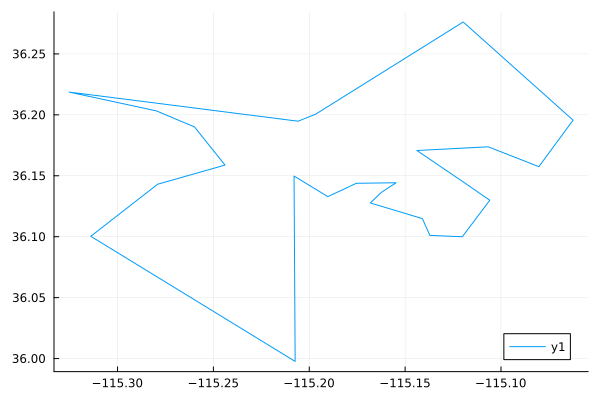

In [158]:
using CSV, DataFrames
sbws_la = DataFrame(CSV.File("Subway_LV.csv"))

using Plots

cycle_idx = getcycle(value.(x), N)
ids = vcat(cycle_idx, cycle_idx[1])

p = plot(sbws_la.long[ids], sbws_la.latt[ids])


In [159]:
using JuMP, Gurobi
N = 25 #the problem is NP-hard we do not solve it for all cities
m2 = Model(optimizer_with_attributes(Gurobi.Optimizer));
set_attribute(m2, "TimeLimit", 60)
JuMP.set_silent(m2)
@variable(m2, x[f=1:N, t=1:N], Bin)
@objective(m2, Min, sum( x[i, j]*dist_mx[i,j] for i=1:N,j=1:N))
@constraint(m2, notself[i=1:N], x[i, i] == 0)
@constraint(m2, oneout[i=1:N], sum(x[i, 1:N]) == 1)
@constraint(m2, onein[j=1:N], sum(x[1:N, j]) == 1)
for f=1:N, t=1:N
    @constraint(m2, x[f, t]+x[t, f] <= 1)
end
#optimize!(m2)

function callbackhandle(cb)
    cycle_idx =  getcycle(callback_value.(Ref(cb), x), N)
    println("Callback! N= $N cycle_idx: $cycle_idx of length: $(length(cycle_idx))")
    if length(cycle_idx) < N
        con = @build_constraint(sum(x[cycle_idx,cycle_idx]) <= length(cycle_idx)-1)
        MOI.submit(m2, MOI.LazyConstraint(cb), con)
        print("added a lazy constraint: ")
        println(con)
    end
end
MOI.set(m2, MOI.LazyConstraintCallback(), callbackhandle)

optimize!(m2)



Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-08
Set parameter TimeLimit to value 60
Callback! N= 25 cycle_idx: [1, 2, 19, 7, 18, 9, 12, 11, 16, 5] of length: 10
added a lazy constraint: ScalarConstraint{AffExpr, MathOptInterface.LessThan{Float64}}(x[1,1] + x[2,1] + x[19,1] + x[7,1] + x[18,1] + x[9,1] + x[12,1] + x[11,1] + x[16,1] + x[5,1] + x[1,2] + x[2,2] + x[19,2] + x[7,2] + x[18,2] + x[9,2] + x[12,2] + x[11,2] + x[16,2] + x[5,2] + x[1,19] + x[2,19] + x[19,19] + x[7,19] + x[18,19] + x[9,19] + x[12,19] + x[11,19] + x[16,19] + x[5,19] + x[1,7] + x[2,7] + x[19,7] + x[7,7] + x[18,7] + x[9,7] + x[12,7] + x[11,7] + x[16,7] + x[5,7] + x[1,18] + x[2,18] + x[19,18] + x[7,18] + x[18,18] + x[9,18] + x[12,18] + x[11,18] + x[16,18] + x[5,18] + x[1,9] + x[2,9] + x[19,9] + x[7,9] + x[18,9] + x[9,9] + x[12,9] + x[11,9] + x[16,9] + x[5,9] + x[1,12] + x[2,12] + x[19,12] + x[7,12] + x[18,12] + x[9,12] + x[12,12] + x[11,12] + x[16,12] + x[5,12] + x[1,11] + x[2,

In [160]:
println("Trip length $(objective_value(m2))")

Trip length 152804.0


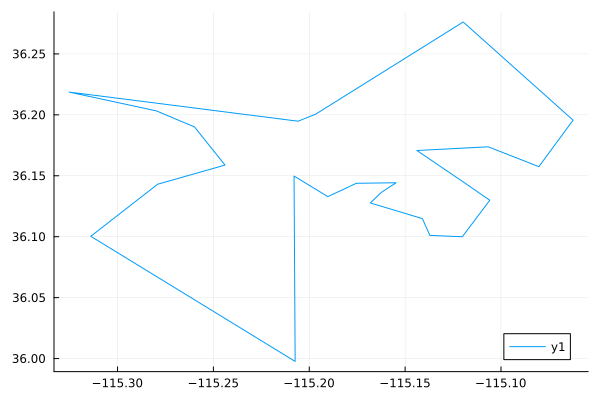

In [161]:
using CSV, DataFrames
sbws_la = DataFrame(CSV.File("Subway_LV.csv"))

using Plots

cycle_idx = getcycle(value.(x), N)
ids = vcat(cycle_idx, cycle_idx[1])

p = plot(sbws_la.long[ids], sbws_la.latt[ids])


### Sample quadratic model - minimizing sum of squares

In [173]:
using LinearAlgebra
# here we generate a sample problem structure
x = rand(Float64,(1000,2))*Diagonal([6,10]) .- [4 3]
ϵ = randn(1000).*2 #errors

a, b, c = 1, 10, 7 # values we are trying to estimate
A = [a b/2;b/2 c]

# y = a * x₁² + b*x₁x₂ + c x₂²
y = (x * A ) .* x * [1;1] .+ ϵ # explained variable
;
y'

1×1000 adjoint(::Vector{Float64}) with eltype Float64:
 -0.510673  -5.66885  100.555  8.75591  …  9.83742  -24.8734  -18.5445

In [174]:
m = Model(optimizer_with_attributes(Ipopt.Optimizer)); 

@variable(m, aa[1:2,1:2])

function errs(aa)
   sum((y .- (x * aa ) .* x * [1;1]) .^ 2)
end

@objective(m, Min, errs(aa))

optimize!(m)


This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3279517e+07 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [175]:
A

2×2 Matrix{Float64}:
 1.0  5.0
 5.0  7.0

In [176]:
value.(aa)

2×2 Matrix{Float64}:
 1.00277  4.99701
 4.99701  6.99339

In [177]:
using Gurobi, JuMP


m = Model(optimizer_with_attributes(Gurobi.Optimizer)); 
@variable(m, aa[1:2,1:2])

function errs(aa)
   sum((y .- (x * aa ) .* x * [1;1]) .^ 2)
end

@objective(m, Min, errs(aa))

optimize!(m)
status = termination_status(m)

println("Cost: $(objective_value(m))")
res = value.(aa)
println("aa=$res")
println("a, b, c = $(res[1,1]), $(res[1,2]+res[2,1]), $(res[2,2])")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-08
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 0 rows, 4 columns and 0 nonzeros
Model fingerprint: 0xf10cb4c6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+04, 4e+06]
  QObjective range [7e+04, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.02s
Presolved: 0 rows, 4 columns, 0 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 7
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          D

### Modelling pandemic dynamics in a small community

In [167]:
using Ipopt, JuMP, LinearAlgebra
obs_cases = vcat(1,2,4,8,15,27,44,58,55,32,12,3,1,zeros(13))
SI_max = length(obs_cases)
N = 300

300

In [168]:
obs_cases'

1×26 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  2.0  4.0  8.0  15.0  27.0  44.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [169]:
using JuMP, Ipopt
m = Model(optimizer_with_attributes(Ipopt.Optimizer, ("print_level"=>2))); 
@variable(m, 0.5 <= α <= 1.5)
@variable(m, 0.05 <= β <= 70)
@variable(m, 0 <= I_[1:SI_max] <= N)

@variable(m, 0 <= S[1:SI_max]  <= N)
@variable(m, ε[1:SI_max])
@constraint(m, ε .== I_ .- obs_cases  )
@constraint(m, I_[1] == 1)
for i=2:SI_max
   @NLconstraint(m, I_[i] == β*(I_[i-1]^α)*S[i-1]/N)
end

@constraint(m, S[1] == N)
for i=2:SI_max
   @constraint(m, S[i] == S[i-1]-I_[i])
end

@NLobjective(m, Min, sum(ε[i]^2 for i in 1:SI_max))
println(m)

Min ε[1] ^ 2.0 + ε[2] ^ 2.0 + ε[3] ^ 2.0 + ε[4] ^ 2.0 + ε[5] ^ 2.0 + ε[6] ^ 2.0 + ε[7] ^ 2.0 + ε[8] ^ 2.0 + ε[9] ^ 2.0 + ε[10] ^ 2.0 + ε[11] ^ 2.0 + ε[12] ^ 2.0 + ε[13] ^ 2.0 + ε[14] ^ 2.0 + ε[15] ^ 2.0 + ε[16] ^ 2.0 + ε[17] ^ 2.0 + ε[18] ^ 2.0 + ε[19] ^ 2.0 + ε[20] ^ 2.0 + ε[21] ^ 2.0 + ε[22] ^ 2.0 + ε[23] ^ 2.0 + ε[24] ^ 2.0 + ε[25] ^ 2.0 + ε[26] ^ 2.0
Subject to
 -I_[1] + ε[1] == -1
 -I_[2] + ε[2] == -2
 -I_[3] + ε[3] == -4
 -I_[4] + ε[4] == -8
 -I_[5] + ε[5] == -15
 -I_[6] + ε[6] == -27
 -I_[7] + ε[7] == -44
 -I_[8] + ε[8] == -58
 -I_[9] + ε[9] == -55
 -I_[10] + ε[10] == -32
 -I_[11] + ε[11] == -12
 -I_[12] + ε[12] == -3
 -I_[13] + ε[13] == -1
 -I_[14] + ε[14] == 0
 -I_[15] + ε[15] == 0
 -I_[16] + ε[16] == 0
 -I_[17] + ε[17] == 0
 -I_[18] + ε[18] == 0
 -I_[19] + ε[19] == 0
 -I_[20] + ε[20] == 0
 -I_[21] + ε[21] == 0
 -I_[22] + ε[22] == 0
 -I_[23] + ε[23] == 0
 -I_[24] + ε[24] == 0
 -I_[25] + ε[25] == 0
 -I_[26] + ε[26] == 0
 I_[1] == 1
 S[1] == 300
 I_[2] - S[1] + S[2] == 0
 I_[3] 

In [170]:

optimize!(m)

println("Cost: $(objective_value(m))")
println("α=$(value(α))\nβ=$(value(β))")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Cost: 0.0
α=0.9962811171883259
β=2.0123538624257815


In [171]:
round.(value.(I_), digits=2)

26-element Vector{Float64}:
  1.0
  2.01
  4.01
  7.87
 14.99
 26.99
 43.67
 57.89
 54.52
 31.73
 11.84
  3.5
  0.96
  0.26
  0.07
  0.02
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0